In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
from jcm.model import SpeedyModel
from jcm.params import Parameters

def make_ones_dinosaur_StateWithTime_object(state, choose_sim_time = jnp.float32(1.0)):
    return jtu.tree_map(lambda x: jnp.ones_like(x), state)

def make_zeros_dinosaur_StateWithTime_object(state, choose_sim_time = jnp.float32(0.0)):
    zero_state = jtu.tree_map(lambda x: jnp.zeros_like(x), state)
    # zero_state.temperature_variation = zero_state.temperature_variation.at[-1, 10:25, 10:25].set(1.0)
    # zero_state.temperature_variation = zero_state.temperature_variation.at[-1, 15:20, 15:20].add(1.0)
    return zero_state
    
def make_zeros_parameters_object(params):
    def make_tangent(x):
        if jnp.issubdtype(jnp.result_type(x), jnp.bool_):
            return np.zeros((), dtype=jax.dtypes.float0)
        elif jnp.issubdtype(jnp.result_type(x), jnp.integer):
            return np.zeros((), dtype=jax.dtypes.float0)
        else:
            return jnp.zeros_like(x)
    return jtu.tree_map(lambda x: make_tangent(x), params)

def make_ones_prediction_object(predictions):
    return jtu.tree_map(lambda x: jnp.ones_like(x), predictions)

def make_zeros_prediction_object(predictions):
    return jtu.tree_map(lambda x: jnp.zeros_like(x), predictions)

jax.config.update('jax_disable_jit', False) # Turn off JIT because of an issue in shortwave_radiation.py:169
jax.config.update("jax_debug_infs", False) # doesn't add any time since the saved time is otherwise spent getting the nodal quantities
jax.config.update("jax_debug_nans", True) # some physics fields might be nan

def create_model(params):
    model = SpeedyModel(
        time_step=30,
        save_interval=4,
        total_time=3,
        layers=8,
        boundary_file='../jcm/data/bc/t30/clim/boundaries_daily.nc',
        parameters=params,
        post_process=True
    )
    return model

def model_run_wrapper(params):
    model = create_model(params)
    state = model.get_initial_state()
    final_state, predictions = model.unroll(state)
    return final_state

# vjp

In [2]:
params = Parameters.default()
primal, vjp_fn = jax.vjp(model_run_wrapper, params)

In [3]:
def create_cotangent(primal):
    cotangent = jtu.tree_map(lambda x: jnp.zeros_like(x), primal)
    # cotangent = jtu.tree_map(lambda x: jnp.ones_like(x), primal)
    cotangent['physics'].shortwave_rad.ftop = jtu.tree_map(lambda x: jnp.ones_like(x), cotangent['physics'].shortwave_rad.ftop)
    return cotangent
grad = vjp_fn(create_cotangent(primal))

In [4]:
from pprint import pprint

def to_readable_format(x):
    if isinstance(x, jnp.ndarray):
        return x.tolist()
    return x

pprint(jax.tree_util.tree_map(to_readable_format, grad))

(Parameters(convection=ConvectionParameters(psmin=0.0,
                                            trcnv=0.0,
                                            rhil=0.0,
                                            rhbl=0.0,
                                            entmax=0.0,
                                            smf=0.0),
            condensation=CondensationParameters(trlsc=0.0,
                                                rhlsc=0.0,
                                                drhlsc=0.0,
                                                rhblsc=0.0),
            shortwave_radiation=ShortwaveRadiationParameters(albcl=-0.029079396277666092,
                                                             albcls=-504429.0,
                                                             absdry=937408.75,
                                                             absaer=278076.75,
                                                             abswv1=0.0,
                                 

# jvp

In [5]:
params = Parameters.default()
zero_params = make_zeros_parameters_object(params)
tangent = zero_params
# tangent.surface_flux.cds = jnp.array(1.)
# tangent.mod_radcon.emisfc = jnp.array(1.)
tangent.mod_radcon.albsea = jnp.array(1.)
y, jvp_at_x = jax.jvp(model_run_wrapper, (params,), (tangent,))

In [6]:
grad_ds = create_model(params).predictions_to_xarray(jvp_at_x, just_final_state=True)
print(f"dataset size: {grad_ds.nbytes/1e6:.1f}MB")

dataset size: 3.9MB


In [7]:
print(list(grad_ds.variables))

['surface_flux.tskin', 'humidity.qsat', 'surface_flux.shf.2', 'convection.psa', 'shortwave_rad.ozone', 'mod_radcon.tau2.2', 'longwave_rad.rlds', 'mod_radcon.albsfc', 'shortwave_rad.gse', 'surface_flux.hfluxn.1', 'land_model.stl_am', 'longwave_rad.dfabs', 'surface_flux.vstr.2', 'mod_radcon.flux.1', 'surface_flux.v0', 'surface_flux.evap.2', 'surface_flux.slru.2', 'shortwave_rad.cloudstr', 'mod_radcon.flux.2', 'temperature', 'shortwave_rad.ssr', 'mod_radcon.st4a.1', 'humidity.rh', 'shortwave_rad.rsds', 'mod_radcon.ablco2', 'surface_flux.t0', 'mod_radcon.stratc.0', 'mod_radcon.alb_l', 'shortwave_rad.ftop', 'surface_flux.ustr.2', 'surface_flux.ustr.1', 'surface_flux.ustr.0', 'date.model_year', 'land_model.stl_lm', 'surface_flux.vstr.1', 'mod_radcon.tau2.1', 'convection.precnv', 'shortwave_rad.stratz', 'mod_radcon.flux.3', 'condensation.precls', 'shortwave_rad.qcloud', 'condensation.dtlsc', 'surface_flux.u0', 'surface_flux.slru.1', 'longwave_rad.slr', 'mod_radcon.tau2.3', 'vorticity', 'mod_r

gradient of surface_flux.tskin is 0.0
gradient of humidity.qsat is 0.0
gradient of surface_flux.shf.2 is 0.0
gradient of convection.psa is 0.0
gradient of shortwave_rad.ozone is 0.0
gradient of mod_radcon.tau2.2 is -0.0
gradient of longwave_rad.rlds is 0.0
gradient of shortwave_rad.gse is 0.0
gradient of land_model.stl_am is 0.0
gradient of surface_flux.vstr.2 is 0.0
gradient of mod_radcon.flux.1 is 0.0
gradient of surface_flux.v0 is 0.0
gradient of surface_flux.evap.2 is 0.0
gradient of surface_flux.slru.2 is 0.0
gradient of shortwave_rad.cloudstr is 0.0
gradient of mod_radcon.flux.2 is 0.0
gradient of temperature is 288.0
gradient of mod_radcon.st4a.1 is 0.0
gradient of humidity.rh is 0.0
gradient of shortwave_rad.rsds is 0.0
gradient of surface_flux.t0 is 0.0
gradient of mod_radcon.stratc.0 is 0.0
gradient of mod_radcon.alb_l is 0.0
gradient of surface_flux.ustr.2 is 0.0
gradient of surface_flux.ustr.1 is -0.0
gradient of surface_flux.ustr.0 is -0.0
gradient of land_model.stl_lm is 

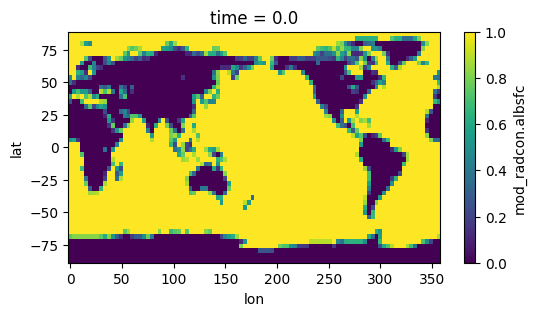

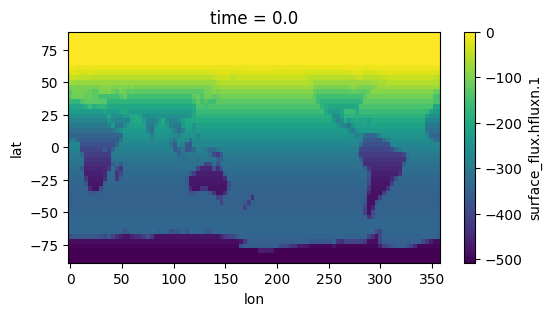

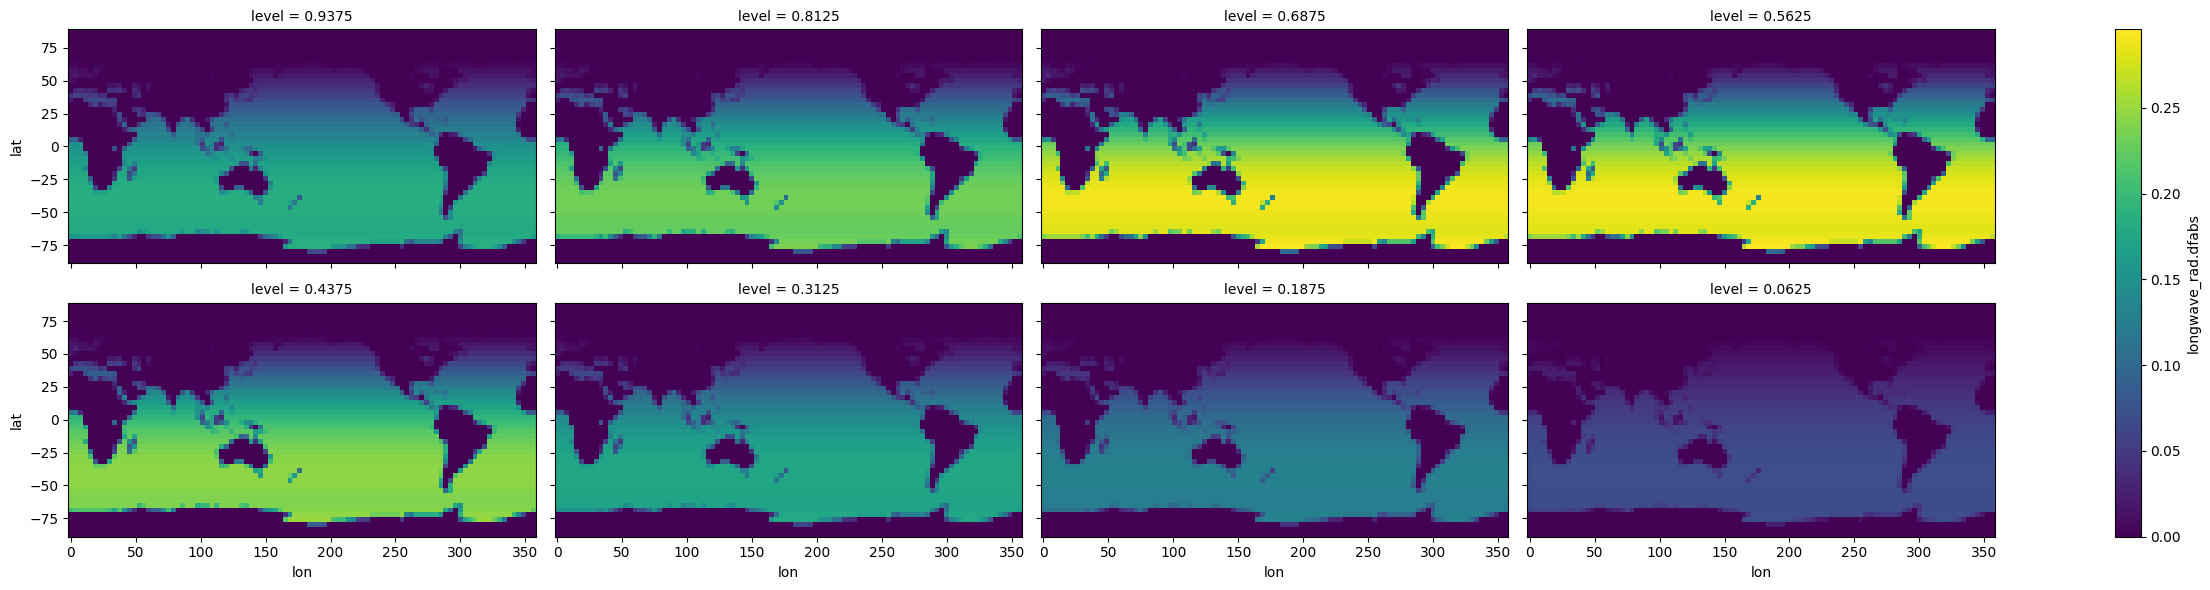

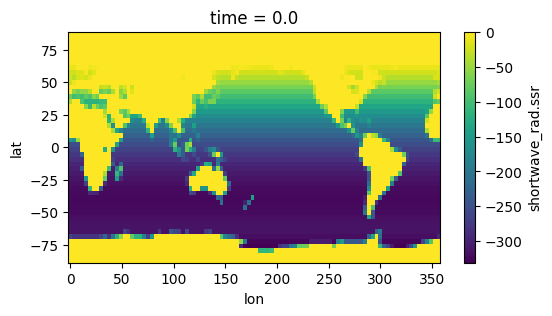

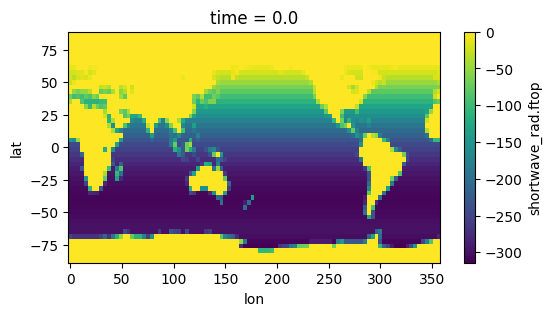

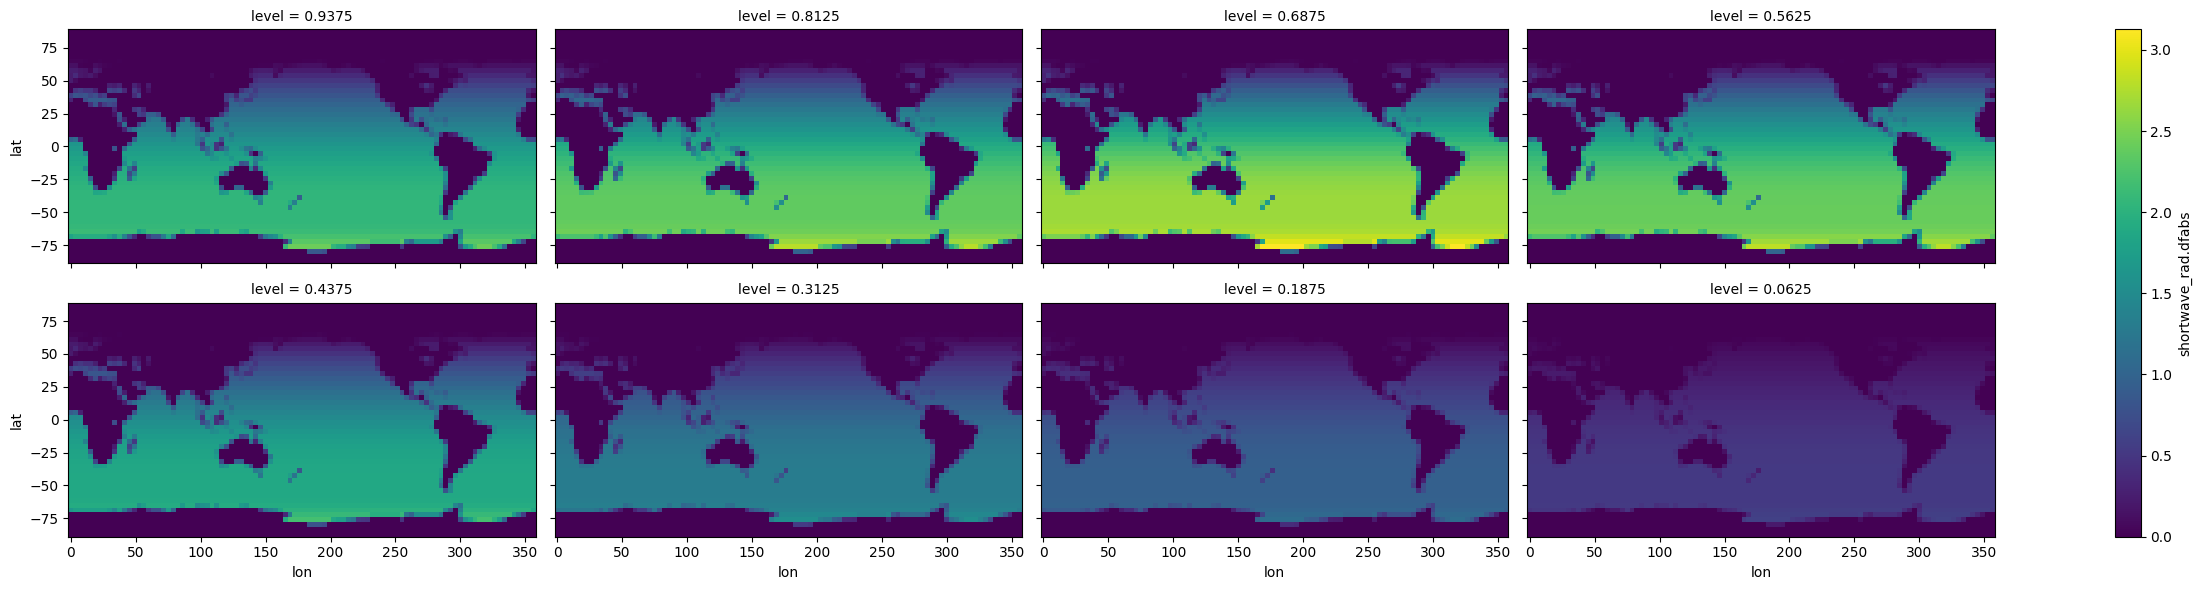

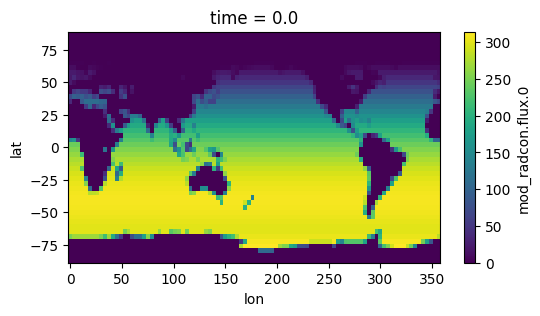

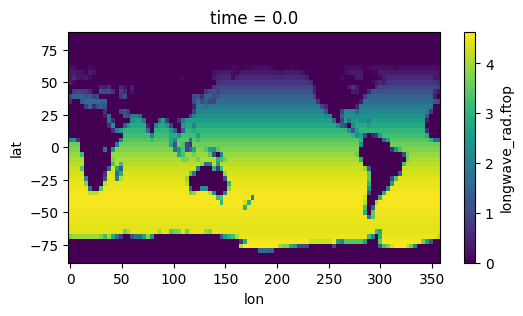

In [8]:
for v in list(grad_ds.variables):
    if v in ['mod_radcon.ablco2', 'convection.iptop', 'date.model_year', 'date.tyear', 'shortwave_rad.icltop', 'lon', 'lat', 'level', 'time']:
        continue
    data = grad_ds[v].isel(time=0)
    if np.nanmax(data) == np.nanmin(data):
        print(f"gradient of {v} is {np.nanmax(data)}")
        continue
    # data = np.log(np.abs(data))
    if 'level' in grad_ds[v].coords:
        data.plot(x='lon', y='lat', size=3, aspect=2, col='level', col_wrap=4);
    else:
        data.plot(x='lon', y='lat', size=3, aspect=2);